In [2]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.optimize as opt
from scipy.optimize import leastsq
from io import StringIO
# from Projects.talys.talysfunctions import GSF, gxs, Photo, dubGauss, dubLor, Lor, brink, Kop, s3, Residual

In [3]:
def gxs(file, length):
    
    startRow = 99999
    lines = ""
    with open(file) as f:
        for n, line in enumerate(f):
            if line.strip().startswith('Energy   Cross section Gamma c.s. c.s./res.prod.cs'):
                startRow = n + 2
            if n in list(range(startRow,startRow+98)):
                lines += line
            if n>startRow+length:
                break
    E, totxs, gxs, ratio = np.loadtxt(StringIO(lines), unpack = True)
    data = np.zeros((len(E),4))
    data[:,0] = E
    data[:,1] = totxs
    data[:,2] = gxs
    data[:,3] = ratio
        
    return data

def GSF(file, length):
    
    startRow = 99999
    lines = ""
    with open(file) as f:
        for n, line in enumerate(f):
            if line.strip().startswith('E       f(M1)        f(E1)        T(M1)        T(E1)'):
                startRow = n + 2
            if n in list(range(startRow,startRow+length)):
                lines += line
            if n>startRow+length:
                break
    E, f_M1, f_E1, T_M1, T_E1 = np.loadtxt(StringIO(lines), unpack = True)
    data = np.zeros((len(E),5))
    data[:,0] = E
    data[:,1] = f_M1
    data[:,2] = f_E1
    data[:,3] = T_M1
    data[:,4] = T_E1
        
    return data

def Residual(x,y,func,bins, title):
    
    if func == Kop:
        p0 = [15.37,1e-5,0.67981,0.0878]
        par, cov = opt.curve_fit(func, x,y ,p0, maxfev = 50000)
        perr= np.sqrt(np.diag(cov))
        
        plt.figure()
        plt.scatter(x,y, marker = '.', color = 'black')
        plt.plot(x,func(x,*par), linewidth = 2, color='red')
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Gamma Strength Function (MeV$^{-3}$)')
        
        fit = func(bins,*par)

        
    if func == Lor:
        p0 = [-3,1e-6,-5]
        par, cov = opt.curve_fit(func, x,y ,p0, maxfev = 50000)
        perr= np.sqrt(np.diag(cov))
        
        plt.figure()
        plt.scatter(x,y, marker = '.', color = 'black')
        plt.plot(x,func(x,*par), linewidth = 2, color='red')
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Gamma Strength Function (MeV$^{-3}$)')
        
        fit = func(bins,*par)
        
    if func == dubLor:
        p0 = [-3,1e-6,-5,-5,1e-6,-5]
        par, cov = opt.curve_fit(func, x,y ,p0, maxfev = 50000)
        perr= np.sqrt(np.diag(cov))
        
        plt.figure()
        plt.scatter(x,y, marker = '.', color = 'black')
        plt.plot(x,func(x,*par), linewidth = 2, color='red')
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Gamma Strength Function (MeV$^{-3}$)')
        
        fit = func(bins,*par)
        
        
    diff = Avg - fit
    
    fig, axs = plt.subplots(3,1, figsize = (8,9), sharex=True)
    a = axs[0]; b = axs[1]; c = axs[2]
    
    i = 45; j =75
    
    
    a.plot(x,func(x,*par), linewidth = 2, color='red', label = 'Fit')
    a.scatter(x,y, marker = '.', color = 'black', label = 'TALYS')
    a.set_ylabel('GSF (MeV$^{-3}$)')
    a.set_xlim(bins[0],bins[-1])
    a.legend(loc = 'best')
    a.set_title(title)
    #a.set_title('Strength 3: Skyrme-Hartree-Fock BCS Model')

    b.errorbar(bins,Avg, yerr = dAvg, label = 'Weighted Avg. of Data',marker = '.', linestyle = '',capsize = 3)
    b.plot(bins, fit, label = 'TALYS', color = 'black')
    b.set_ylabel('f$_{E1}$ (MeV$^{-3}$)')
    b.legend(loc = 'best')
    
    c.ticklabel_format(axis = 'y', style = 'sci',scilimits= (-6,-6))
    c.set_ylim([min(diff)-0.3e-7,max(diff) +0.3e-7])
    c.hlines( y= 0 , xmin = 9.5, xmax = 26, color = 'black')
    c.errorbar(bins, diff, yerr = dAvg, marker = '.', label = 'Difference between TALYS and Data', linestyle = '',capsize = 3)
    c.legend(loc = 'best')
    plt.ylabel('Residuals (MeV$^{-3}$)')
    c.set_xlabel('Energy (MeV)')
    
    return fit, diff, cov

def dubGauss( x, c1, mu1, sigma1, c2, mu2, sigma2):
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def dubLor(x,c1,b1,f1,c2,b2,f2):
    res = c1*(x)/(1+4*((x+b1)/f1)**2)+ c2*(x)/(1+4*((x+b2)/f2)**2)
    return res

def Lor(x,b,c,f):
    return c*(x)/(1+4*((x+b)/f)**2)
# took equation from https://www.surfacesciencewestern.com/wp-content/uploads/ass18_biesinger.pdf

def brink(x,b,c,f): # equation in TALYS manual section 9
    return c*x/((x**2-b**2)**2 + (x**2)*(f**2))

def Kop(x,E_E1,c,T,G): # equation in TALYS manual section 9
    Te = G*((x**2 + 4*(np.pi*T)**2)/E_E1**2)
    return c*((Te*x)/((x**2-E_E1**2)**2+(x*Te)**2)+(0.7*Te*4.0*(np.pi*T)**2)/(E_E1**3))

def s3(x, g, Ei):
    return (2/np.pi)*((g*x**2)/((x**2-Ei**2)**2+(g*x)**2))

Text(0.5, 1.0, '$^{119}$Sn(n,$\\gamma$)$^{120}$Sn Strength: 9')

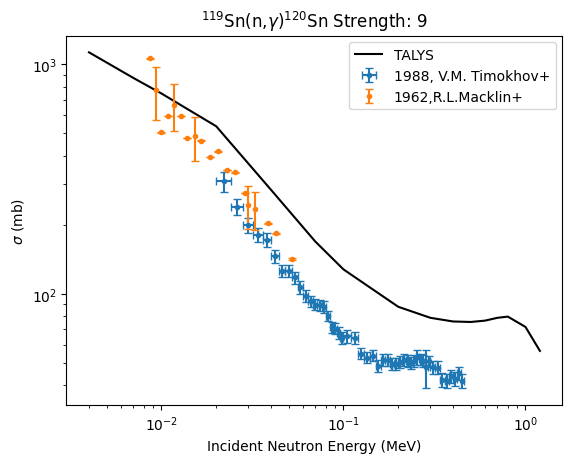

In [4]:
tly = gxs('/home/dhoulihan/Projects/talys/119Sn/Tests/talys.out',86)
strength = 9
# Experimental data
# https://www-nds.iaea.org/exfor/servlet/X4sShowData?db=x4&op=get_plotdata&req=-1&ii=4004&File=E4R_ZV484.zvd.dat.txt
tim = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/xs_exp_data/timavged', unpack = False)
tim[:,0] = tim[:,0]*10**(-3); tim[:,1] = tim[:,1]*10**(-3)

#kaz = np.loadtxt('/home/dhoulihan/Documents/talys/119Sn/xs_exp_data/KAZAKOVdata', unpack = False)
mac = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/xs_exp_data/Macklindata', unpack = False)

i = 8; j=25
plt.figure()
plt.plot(tly[i:j,0], tly[i:j,1], color= 'black',label= 'TALYS')

plt.errorbar((tim[:,0]+tim[:,1])/2, tim[:,2], xerr = abs((tim[:,0]+tim[:,1])/2- tim[:,1]),yerr = tim[:,3], label = "1988, V.M. Timokhov+", marker = '.', linestyle = '',capsize = 3)

plt.errorbar(mac[:,0], mac[:,2]*10**3, yerr = mac[:,3]*10**3, label = "1962,R.L.Macklin+",marker = '.',linestyle = '',capsize = 3)
plt.legend(loc='best')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Incident Neutron Energy (MeV)')
plt.ylabel(r'$\sigma$ (mb)')
plt.title(r'$^{119}$Sn(n,$\gamma$)$^{120}$Sn Strength: 9')


(5.0, 28.0)

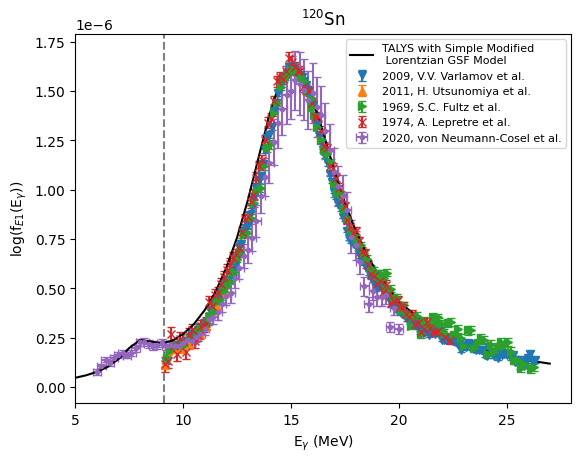

In [29]:
#fE1 = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/Tests/psf050120.E1', unpack = False)
fE1 = GSF('/home/dhoulihan/Projects/talys/119Sn/Tests/talys.out', 86) 
expV = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_2009Var.dat')
expS = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1974Sor.dat')
expU = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_2011Uts.dat')
expfu = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1969Fu1.dat')
expLe = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/photonuclear/fe1_exp_050_120_photoneut_1974Le1.dat')
expBA = np.loadtxt('/home/dhoulihan/Projects/talys/119Sn/PSFall_exp/Neumann-Cosel_120Sndata/fe1_exp_050_120_PP_2020BA.dat')

totdata = np.concatenate((expV,expfu,expLe,expBA))

i = 0; j =75
h = 0 ; k = 172

plt.figure()
plt.errorbar(expV[h:k,0], expV[h:k,2], yerr = expV[h:k,3], label = '2009, V.V. Varlamov et al.', marker = 'v', linestyle = '',capsize = 3)
plt.errorbar(expU[:,0], expU[:,2], yerr = expU[:,3], label = '2011, H. Utsunomiya et al.', marker = '^', linestyle = '',capsize = 3)
plt.errorbar(expfu[:,0], expfu[:,2], yerr = expfu[:,3], label = '1969, S.C. Fultz et al.', marker = '>', linestyle = '',capsize = 3)
plt.errorbar(expLe[:,0], expLe[:,2], yerr = expLe[:,3], label = '1974, A. Lepretre et al.', marker = 'x', linestyle = '',capsize = 3)
plt.errorbar(expBA[:,0], expBA[:,2], xerr = expBA[:,1], yerr = expBA[:,3], label = '2020, von Neumann-Cosel et al.', marker = '.', linestyle = '',capsize = 3)

#plt.errorbar(expS[:,0], expS[:,2], yerr = expS[:,3], label = '1974, Sorokin et al.', marker = '.', linestyle = '',capsize = 3)

plt.axvline(x = 9.104,color = 'gray', linestyle = '--')
plt.plot(fE1[i:j,0], fE1[i:j,2], label = 'TALYS with Simple Modified \n Lorentzian GSF Model'.format(strength), color = 'black')
plt.legend(loc = 'best', fontsize = 8)
plt.xlabel('E$_{\gamma}$ (MeV)')
plt.ylabel('log(f$_{E1}$(E$_{\gamma}$))')
plt.title('$^{120}$Sn')
# plt.yscale('log')
plt.xlim(5, 28)
# plt.ylim(5e-8,2e-6)

In [21]:
# bins = np.linspace(5,26,110)

# data = np.concatenate((expV,expfu, expLe, expU,expBA))
# W = []
# Avg = np.zeros(len(bins)); favg = np.zeros(len(bins)); dE = np.zeros(len(bins))
# dAvg = np.zeros(len(bins)); x = np.zeros(len(bins)); w = np.zeros(len(bins))
# digitized = np.digitize(data[:,0], bins)
# #Avg = [np.average(data[digitized == i,0], weights = data[digitized == i, 3]**(-2)) for i in range(len(bins))]
# #bin_means = [data[digitized == i].average(axis = 2, weights = data[:,3]**(-2))

# for i in range(len(bins)):
#     if np.sqrt(sum((1/(data[digitized == i,3]*sum(data[digitized == j,3]**(-2))))**2)) > 0:
#         for j in range(len(bins)):
#             Avg[i] = sum(data[digitized == i,2]*data[digitized == i, 3]**(-2))/sum(data[digitized == i, 3]**(-2))
#             dAvg[i] = np.sqrt(sum((1/(data[digitized == i,3]*sum(data[digitized == j,3]**(-2))))**2))
#            # dE[i] = np.sqrt(sum((1/(data[digitized == i,1]*sum(data[digitized == j,1]**(-2))))**2))

[ 0.21092648  0.75856182  7.99733889 11.1936956   2.25852068 15.46954643] [0.05724966 0.27844006 0.18160359 0.10227419 0.02879251 0.01781925]


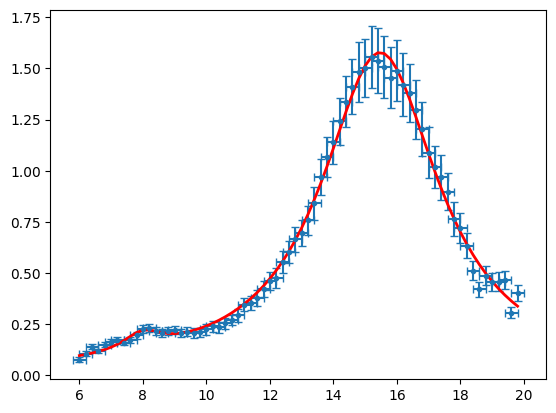

In [162]:
def dubLor(x,c1,HWHM,x0,c2,HWHM2,x20):
    return (c1/np.pi)*(HWHM/((x-x0)**2+(HWHM)**2)) + (c2/np.pi)*(HWHM2/((x-x20)**2+(HWHM2)**2))

exptot = expBA
s = 0; f = -1

p0 = [1,2.3,8,1.6,3,15.9]
par, cov = opt.curve_fit(dubLor, exptot[:,0], exptot[:,2]*1e6,p0, maxfev = 50000)
perr= np.sqrt(np.diag(cov))

# Scaling the data so that the parameter values are not orders of magnitude different, which should help the algorithm to fit
plt.figure()
plt.errorbar(exptot[s:f,0], exptot[s:f,2]*1e6, xerr = exptot[s:f,1],yerr = exptot[s:f,3]*1e6, label = '2020, von Neumann-Cosel et al.', marker = '.', linestyle = '',capsize = 3)
# plt.errorbar(exptot, binned_y_values, xerr = binned_x_uncertainties,yerr = binned_y_uncertainties, label = '2020, von Neumann-Cosel et al.', marker = '.', linestyle = '',capsize = 3)
plt.plot(expBA[s:f,0],dubLor(expBA[s:f,0],*par), linewidth = 2, color='red')
print(par, perr)
# print('pdr=', par[2], '+/-', perr[2])
# print('gdr=', par[5],'+/-', perr[5])

# Now try Emcee

In [239]:
from scipy.optimize import minimize
# finding maximum likelihood parameters

# Determine errors from model fit from before
# data = np.concatenate((expV,expfu, expLe, expU,expBA)) # total data set
data = expBA

HighP = par + perr ; lowP = par - perr

Highend = dubLor(data[:,0],*HighP) ; Lowend = dubLor(data[:,0], *lowP)

Modelerr = abs((Highend-Lowend))

def log_likelihood(theta, x, y, yerr):
    c1,HWHM,x0,c2,HWHM2,x20 = theta
    model = (c1/np.pi)*(HWHM/((x-x0)**2+(HWHM)**2)) + (c2/np.pi)*(HWHM2/((x-x20)**2+(HWHM2)**2))
    sigma2 = yerr**2 #+ model**2 * np.exp(2 * log_f )
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))

X = (data[:,0],data[:,2]*1e6, data[:,3]*1e6)
# np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)

initial = np.array([*p0]) + 0.1 * np.random.randn(6)

soln = minimize(nll, initial, args=(X[0],X[1],X[2]))

c1_ml,HWHM_ml,x0_ml,c2_ml,HWHM2_ml,x20_ml = soln.x

print("Maximum likelihood estimates:")
print("c1 = {0:.3f}".format(c1_ml))
print("HWHM = {0:.3f}".format(HWHM_ml))
print("x0 = {0:.3f}".format(x0_ml))
print("c2 = {0:.3f}".format(c2_ml))
print("HWHM2 = {0:.3f}".format(HWHM2_ml))
print("x20 = {0:.3f}".format(x20_ml))
# print("log_f = {0:.9f}".format(np.exp(log_f_ml)))
# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
# plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
# plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
# plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y");

Maximum likelihood estimates:
c1 = 0.324
HWHM = 1.154
x0 = 8.002
c2 = 10.841
HWHM2 = 2.135
x20 = 15.481


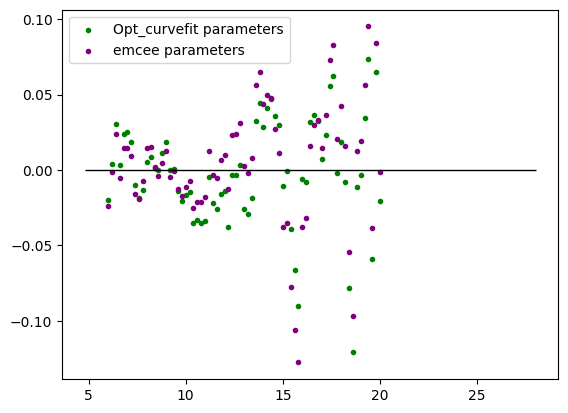

In [240]:
diff1 = np.zeros(len(data[:,0])); diff2 = np.zeros(len(data[:,0]))
for i in range(len(data[:,0])):
    diff1[i] = data[i,2]*1e6 - dubLor(data[:,0],*par)[i]
    diff2[i] = data[i,2]*1e6 - dubLor(data[:,0], c1_ml,HWHM_ml,x0_ml,c2_ml,HWHM2_ml,x20_ml)[i]


plt.figure()
plt.scatter(data[:,0], diff1, color = 'green', marker = '.', label = 'Opt_curvefit parameters')
plt.scatter(data[:,0], diff2, color = 'purple', marker = '.', label = 'emcee parameters')
plt.legend(loc = 'best')

plt.hlines(0, xmin = 4.8, xmax = 28, color = 'black', linewidth = 1)

Set up the prior

In [241]:
def log_prior(theta):
    c1,HWHM,x0,c2,HWHM2,x20 = theta
    if -1 < c1 < 5 and 0 < HWHM < 5 and 0 < x0 < 10 and -1 < c2<12 and 0 < HWHM2 < 8 and 10 < x20 < 20:
        return 0.0
    return -np.inf

def log_probability(theta, x,gs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x,gs, sigma)

In [242]:
import emcee
import time
from multiprocessing import Pool
from emcee.moves import StretchMove

pos = soln.x + 1e-4 * np.random.randn(32, 6)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(data[:,0], data[:,2]*1e6, data[:,3]*1e6), moves=StretchMove(a=2.0))
start = time.time()
sampler.run_mcmc(pos, 10000, progress=True);
end = time.time()
multi_time = end - start
print("Multiprocessing took {0:.1f} seconds".format(multi_time))
# print("{0:.1f} times faster than serial".format(serial_time / multi_time))

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:12<00:00, 818.14it/s]

Multiprocessing took 12.2 seconds


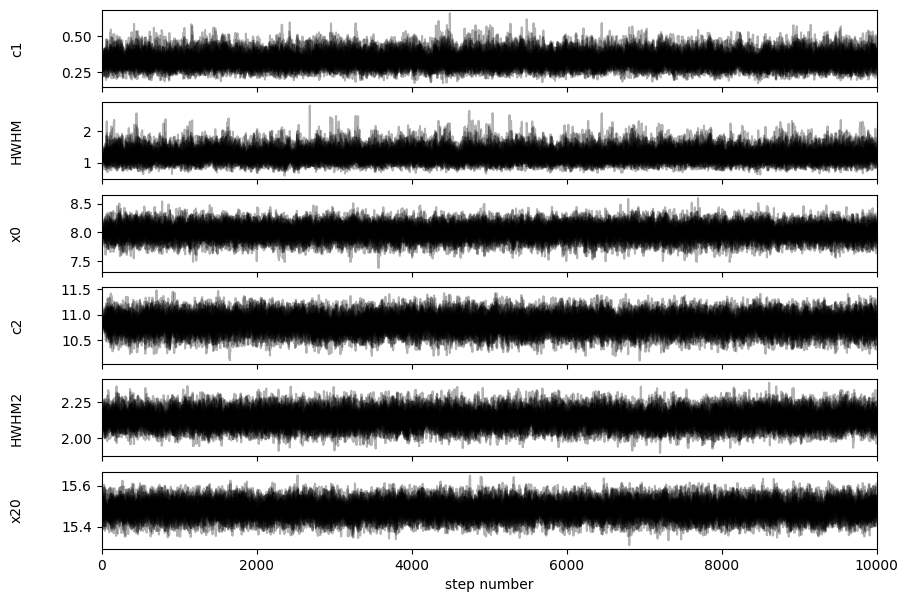

In [243]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['c1','HWHM','x0','c2','HWHM2','x20']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [244]:
tau = sampler.get_autocorr_time()
print(tau)

[65.96061371 67.08045724 64.31321144 64.4346365  71.21170321 66.13050602]


In [245]:
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
print(flat_samples.shape)

(20896, 6)


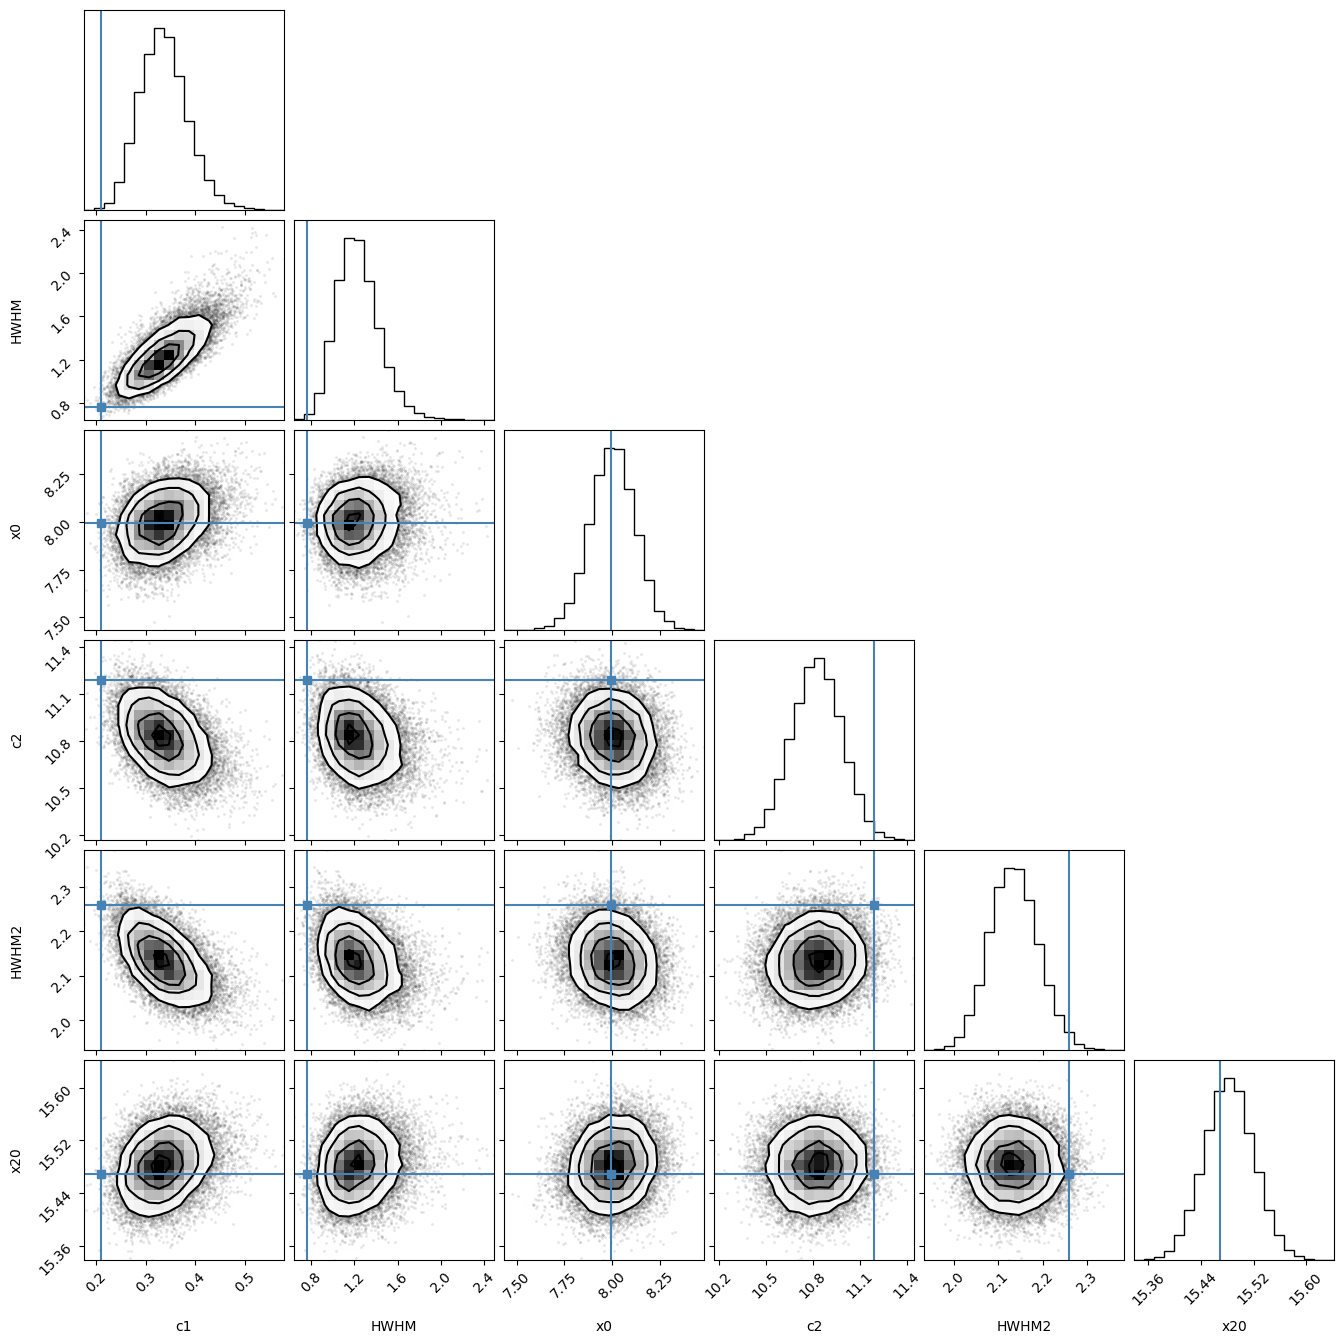

In [246]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths= par
);

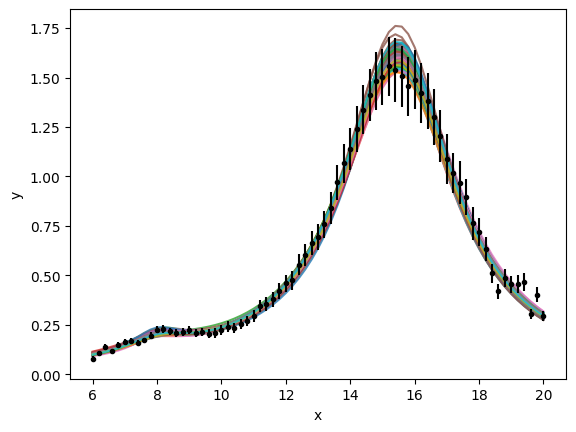

In [233]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(data[:,0], dubLor(data[:,0],*sample[:6]), alpha=0.8)
plt.errorbar(data[:,0], data[:,2]*1e6, yerr=data[:,3]*1e6, fmt=".k", capsize=0)
# plt.plot(data[:,0], dubLor(data[:,0],*par), "k", label="opt.curve_fit")
# plt.legend(loc = 'best')
# plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

In [230]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print(par, perr)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[ 0.21092648  0.75856182  7.99733889 11.1936956   2.25852068 15.46954643] [0.05724966 0.27844006 0.18160359 0.10227419 0.02879251 0.01781925]
